# 05. Going modular

**Ressources:**
* Book version of the course materials for 04: https://www.learnpytorch.io/04_pytorch_custom_datasets/


## 0. Importing PyTorch and setting up device-agnostic code

In [1]:
import torch
from torch import nn

# Check PyTorch version
torch.__version__

'2.4.0+cu121'

In [151]:
# Setup device-agnostic code
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

## 1. Get the data

Our dataset is a subset of the Food101 dataset.

In [3]:
import os
import zipfile

from pathlib import Path

import requests

# Setup data directory
data_dir = Path('data/')
image_dir = data_dir / 'images'

# If the data directory already exists, we assume it contains the data
if image_dir.exists():
    print('Data directory already exists. Skipping download.')
else:
    # Download the dataset
    print('Downloading dataset...')
    image_dir.mkdir(parents=True, exist_ok=True)

    with open(data_dir / 'images.zip', 'wb') as f:
        print(f"Downloading images.zip on {data_dir}")
        response = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        f.write(response.content)

    # Unzip the dataset
    with zipfile.ZipFile(data_dir / 'images.zip', 'r') as z:
        print(f"Extracting images on {image_dir}")
        z.extractall(image_dir)

Data directory already exists. Skipping download.


## 2. Becomming one with data

In [153]:
import os

def walk_through_dir(dir_path: Path) -> None:
    """Walks through dir_path returning its directories and files.

    Args:
        dir_path (Path): The target directory.
    """
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

        if len(filenames) > 0:
            print(f"Example file(s) (out of {len(filenames)} total): {filenames[:2]}")

        print()

In [154]:
walk_through_dir(image_dir)

There are 2 directories and 0 images in 'data/images'.

There are 3 directories and 0 images in 'data/images/test'.

There are 0 directories and 25 images in 'data/images/test/pizza'.
Example file(s) (out of 25 total): ['1152100.jpg', '1503858.jpg']

There are 0 directories and 19 images in 'data/images/test/steak'.
Example file(s) (out of 19 total): ['100274.jpg', '1016217.jpg']

There are 0 directories and 31 images in 'data/images/test/sushi'.
Example file(s) (out of 31 total): ['1172255.jpg', '1230335.jpg']

There are 3 directories and 0 images in 'data/images/train'.

There are 0 directories and 78 images in 'data/images/train/pizza'.
Example file(s) (out of 78 total): ['2760984.jpg', '3505182.jpg']

There are 0 directories and 75 images in 'data/images/train/steak'.
Example file(s) (out of 75 total): ['234626.jpg', '3245622.jpg']

There are 0 directories and 72 images in 'data/images/train/sushi'.
Example file(s) (out of 72 total): ['268990.jpg', '2720223.jpg']



In [155]:
# Setup the train and test directories
train_dir = image_dir / 'train'
test_dir = image_dir / 'test'

train_dir, test_dir

(PosixPath('data/images/train'), PosixPath('data/images/test'))

### 2.1 Visualizing the data

Image path: data/images/test/sushi/719108.jpg
Image class: sushi
Image size: (512, 512)
Image:


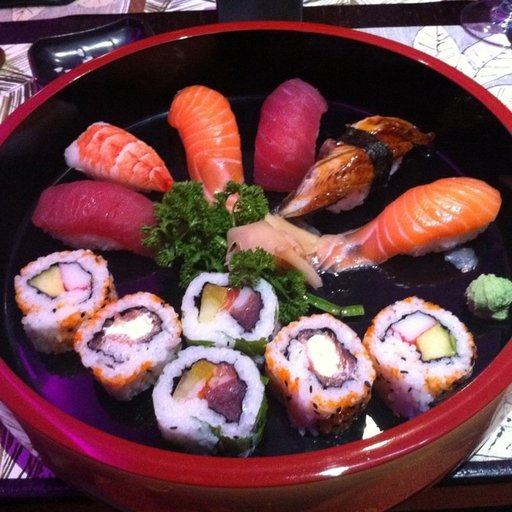

In [156]:
import random 
from PIL import Image

# 1. Get all image paths
train_image_paths = [path for path in image_dir.rglob('*.jpg')]

# 2. Pick a random image path
random_image_path = random.choice(train_image_paths)

# 3. Get the label
class_name = random_image_path.parent.name

# 4. Open the image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Image path: {random_image_path}")
print(f"Image class: {class_name}")
print(f"Image size: {img.size}")
print("Image:")

# 5. Display the image
img


(np.float64(-0.5), np.float64(511.5), np.float64(511.5), np.float64(-0.5))

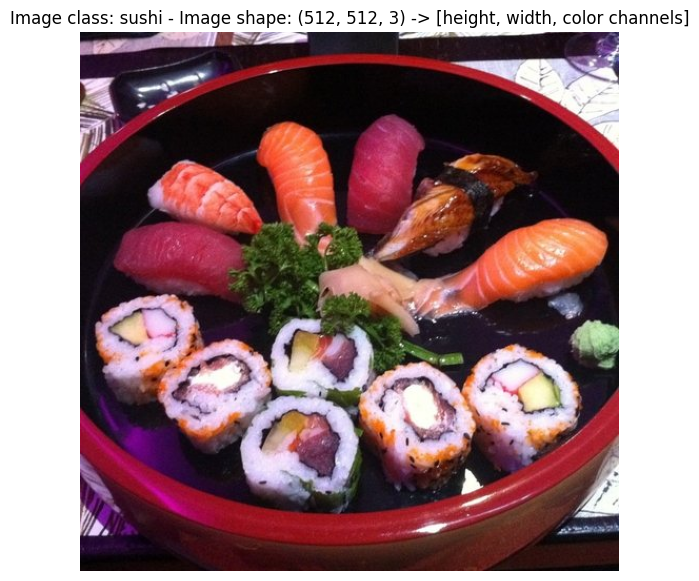

In [157]:
import numpy as np
import matplotlib.pyplot as plt

# Turn an image into NumPy array
img_array = np.array(img)

# Plot the image with matplotlib
plt.figure(figsize=(7, 7))
plt.imshow(img_array)
plt.title(f"Image class: {class_name} - Image shape: {img_array.shape} -> [height, width, color channels]")
plt.axis(False)

## 3. Transforming data

Before we can use our image data with a PyTorch model, we need to turn it into a format the model expects.
1. Turn our target data into tensors (in our case )
2. Turn it into a `torch.utils.data.Dataset` object (a format PyTorch can work with) and then create a `torch.utils.data.DataLoader` (something that helps PyTorch work with data in batches).

In [158]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import v2 as transforms

### 3.1 Transforming data with `torchvision.transforms`

In [159]:
# Write a transform for image
data_transform = transforms.Compose([
    # Convert the image to a PyTorch tensor
    transforms.ToImage(),

    # Resize the images to (64, 64) (H x W)
    transforms.Resize((64, 64)),

    # Flip the data randomly on the horizontal axis
    transforms.RandomHorizontalFlip(),

    # Change the type of the data to PyTorch tensor to float32
    transforms.ToDtype(torch.float32, scale=True),

    # Normalize the image
    # transforms.Normalize(mean=[0.485, 0.456, 0.406],
    #                      std=[0.229, 0.224, 0.225]),

    # Convert the image to a PyTorch tensor
    transforms.ToImage(),
])

In [160]:
data_transform(img)

Image([[[0.1255, 0.1529, 0.1843,  ..., 0.2471, 0.2824, 0.2941],
        [0.5647, 0.6118, 0.6824,  ..., 0.3373, 0.3686, 0.4000],
        [0.5373, 0.5412, 0.5608,  ..., 0.3843, 0.5020, 0.6431],
        ...,
        [0.1373, 0.1333, 0.1294,  ..., 0.1922, 0.1922, 0.1922],
        [0.0510, 0.0510, 0.0510,  ..., 0.1843, 0.1804, 0.1725],
        [0.0392, 0.0392, 0.0471,  ..., 0.0902, 0.0824, 0.0706]],

       [[0.0941, 0.1098, 0.1373,  ..., 0.1451, 0.1961, 0.2431],
        [0.4392, 0.4745, 0.5333,  ..., 0.2118, 0.2314, 0.3176],
        [0.3922, 0.4039, 0.4118,  ..., 0.2706, 0.3765, 0.5961],
        ...,
        [0.0431, 0.0392, 0.0353,  ..., 0.0745, 0.0745, 0.0784],
        [0.0196, 0.0157, 0.0157,  ..., 0.0706, 0.0706, 0.0706],
        [0.0196, 0.0196, 0.0196,  ..., 0.0431, 0.0431, 0.0392]],

       [[0.1412, 0.1529, 0.1686,  ..., 0.2902, 0.3686, 0.4196],
        [0.5490, 0.5765, 0.6118,  ..., 0.3922, 0.4863, 0.5098],
        [0.5216, 0.5137, 0.4941,  ..., 0.4667, 0.6275, 0.7373],
        ..

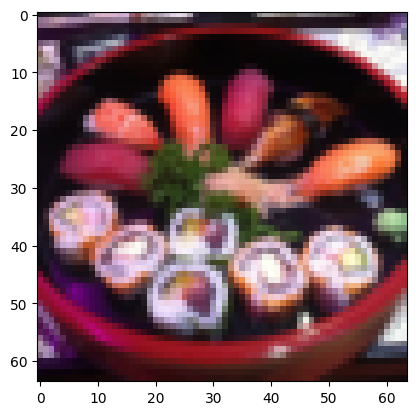

In [161]:
from matplotlib.pyplot import imshow

# Transform the image and transpose the array
transformed_img = (data_transform(img).permute(1, 2, 0))
imshow(transformed_img)


In [162]:
def plot_transformed_images(image_paths, transform, n=3, seed=None):
    """Displays n transformed images from a list of image paths.

    Args:
        image_paths (list): A list of image paths.
        transform (torchvision.transform): A torchvision transformation to apply to the images.
        n (int, optional): The number of image to display. Defaults to 3.
        seed (_type_, optional): The seed. Defaults to None.
    """
    if seed:
        random.seed(seed)

    random_image_paths = random.sample(image_paths, n)

    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, axs = plt.subplots(1, 2, figsize=(10, 6))
            axs[0].imshow(f)
            axs[0].set_title(f"Original image size: {f.size}")
            axs[0].axis(False)

            # Apply the transform and convert the image to NumPy
            transformed_img = transform(f)
            transformed_img = transformed_img.permute(1, 2, 0)

            axs[1].imshow(transformed_img)
            axs[1].set_title(f"Transformed image size: {transformed_img.shape}")
            axs[1].axis(False)
            
        

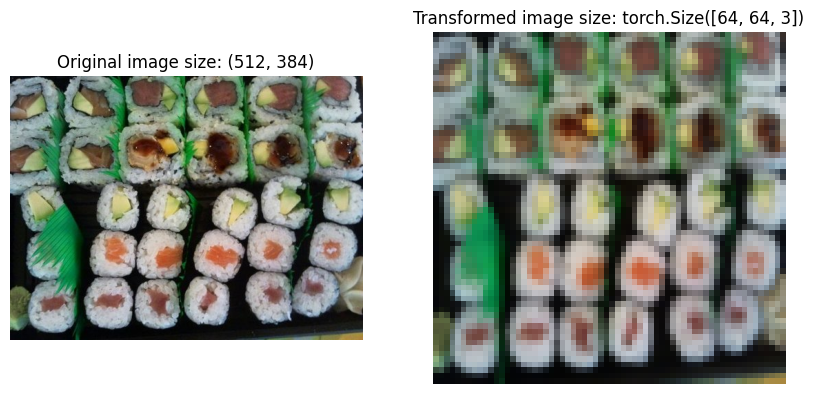

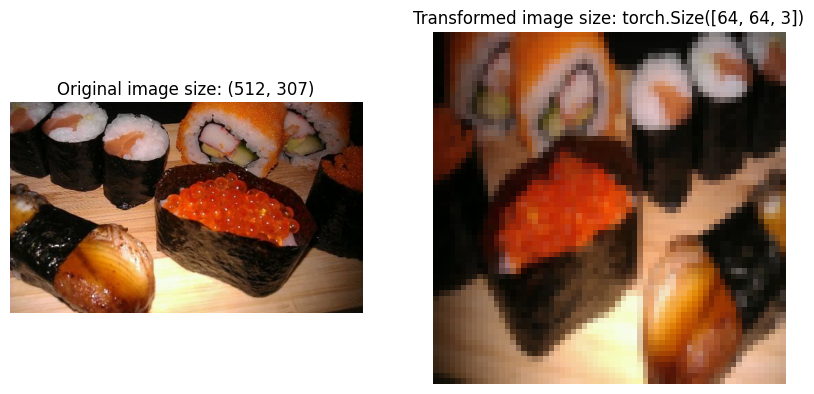

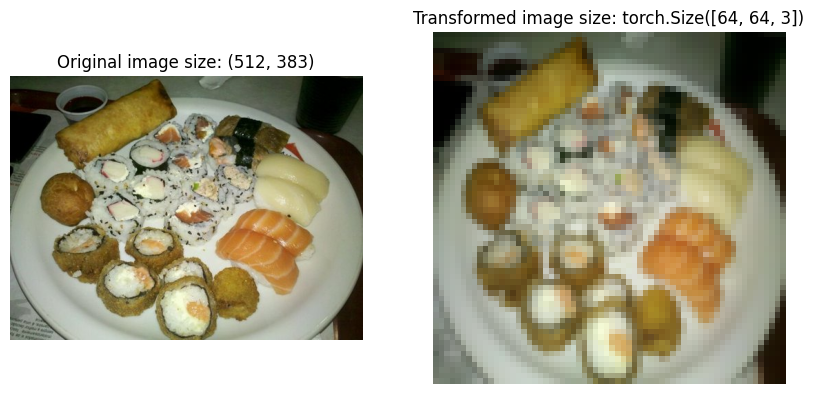

In [163]:
plot_transformed_images(train_image_paths, data_transform)

## 4. Option 1: Loading image data using `ÌmageFolder`

we can load image classification data using `torchvision.datasets.ImageFolder` class. This class expects the data to be organized in the following way:
* Each class has its own directory.
* Each image is inside the class directory.

In [164]:
# Use ImageFolder to create a PyTorch dataset
from torchvision import datasets

train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform,
                                  target_transform=None)

test_data = datasets.ImageFolder(root=test_dir,
                                    transform=data_transform)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/images/train
     StandardTransform
 Transform: Compose(
                  ToImage()
                  Resize(size=[64, 64], interpolation=InterpolationMode.BILINEAR, antialias=True)
                  RandomHorizontalFlip(p=0.5)
                  ToDtype(scale=True)
                  ToImage()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/images/test
     StandardTransform
 Transform: Compose(
                  ToImage()
                  Resize(size=[64, 64], interpolation=InterpolationMode.BILINEAR, antialias=True)
                  RandomHorizontalFlip(p=0.5)
                  ToDtype(scale=True)
                  ToImage()
            ))

In [165]:
# Get the class names
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [166]:
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [167]:
train_data.samples[0]

('data/images/train/pizza/1008844.jpg', 0)

In [168]:
# Index on the train_data Dataset to get a single image and label
img, label = train_data[0][0], train_data[0][1]
print(f"Image tensor:\n{img}\n")
print(f"Image label: {label}\n")
print(f"Image shape: {img.shape}\n")

Image tensor:
Image([[[0.1137, 0.1020, 0.0980,  ..., 0.1255, 0.1216, 0.1176],
        [0.1059, 0.0980, 0.0980,  ..., 0.1294, 0.1294, 0.1294],
        [0.1020, 0.0980, 0.0941,  ..., 0.1333, 0.1333, 0.1333],
        ...,
        [0.1098, 0.1098, 0.1255,  ..., 0.1686, 0.1647, 0.1686],
        [0.0902, 0.0941, 0.1098,  ..., 0.1686, 0.1647, 0.1686],
        [0.0863, 0.0863, 0.0980,  ..., 0.1686, 0.1647, 0.1647]],

       [[0.0745, 0.0706, 0.0745,  ..., 0.0588, 0.0588, 0.0588],
        [0.0745, 0.0706, 0.0745,  ..., 0.0627, 0.0627, 0.0627],
        [0.0706, 0.0745, 0.0745,  ..., 0.0706, 0.0706, 0.0706],
        ...,
        [0.1255, 0.1333, 0.1373,  ..., 0.2510, 0.2392, 0.2392],
        [0.1098, 0.1176, 0.1255,  ..., 0.2510, 0.2392, 0.2314],
        [0.1020, 0.1059, 0.1137,  ..., 0.2431, 0.2353, 0.2275]],

       [[0.0941, 0.0902, 0.0902,  ..., 0.0157, 0.0196, 0.0196],
        [0.0902, 0.0863, 0.0902,  ..., 0.0196, 0.0157, 0.0196],
        [0.0902, 0.0902, 0.0902,  ..., 0.0157, 0.0157, 0.019

### 4.1 Create a DataLoader

In [169]:
# Create train and test data loaders
BATCH_SIZE = 32

train_dataloader = DataLoader(train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=2,
                              shuffle=True)

test_dataloader = DataLoader(test_data,
                             batch_size=BATCH_SIZE,
                             num_workers=2,
                             shuffle=False)

# Check the shape of the first batch
for images, labels in train_dataloader:
    print(f"Image batch shape: {images.shape}")
    print(f"Image label shape: {labels.shape}")
    break


Image batch shape: torch.Size([32, 3, 64, 64])
Image label shape: torch.Size([32])


In [170]:
train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7eb5fbeb8b60>,
 <torch.utils.data.dataloader.DataLoader at 0x7eb529d909b0>)

In [171]:
img, label = next(iter(train_dataloader))

print(f"Image batch shape: {img.shape}")
print(f"Image label shape: {label.shape}")

Image batch shape: torch.Size([32, 3, 64, 64])
Image label shape: torch.Size([32])


## 5. Option 2: Loading Image Data with Custom `Dataset` 

1. Want to be able to load images from file
2. Want to be able to get class names the Dataset
3. Want to be able to get classes as dictionary from the Dataset

Pros:
* Can create a `Dataset` out of almost anything
* Not limited to PyTorch pre-built `Dataset` functions

Cons:
* Even though you could create `Dataset` out of almost anything, it's not always easy and it's doesn't always work
* Using a custom `Dataset` can be more complex than using a pre-built one

In [172]:
import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision.transforms import v2 as transforms
from typing import Tuple, Dict, List

In [173]:
# Instance of torchvision.datasets.ImageFolder()

train_data.classes, train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.1 Creating a helper function to get class names


In [174]:
# Setup path for target directory
target_directory = train_dir
print(f"Target directory: {target_directory}")

# Get the class names from the target directory
class_names = [path.name for path in target_directory.glob('*')]

def get_class_names(data_dir: Path) -> Tuple[List[str], Dict[str, int]]:
    """Returns the class names in a dataset.

    Args:
        data_dir (Path): The target directory.

    Returns:
        Tuple[List[str], Dict[str, int]]: A tuple containing a list of class names and a dictionary mapping class names to indices.
    """

    classes = [path.name for path in data_dir.glob('*')]
    class_to_idx = {path.name: i for i, path in enumerate(data_dir.glob('*'))}

    if len(classes) == 0:
        raise Exception(f"No class names found in {data_dir}")
    
    return classes, class_to_idx

Target directory: data/images/train


In [175]:
print(get_class_names(target_directory))

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})


### 5.2 Create a custom `Dataset` to replicate `ImageFolder`

In [176]:
class CustomImageDataset(Dataset):
    """A custom PyTorch dataset for loading images.

    Args:
        Dataset (Path): The target directory.
    """
    def __init__(self, root_dir, transform=None) -> None:
        """Initializes a custom PyTorch dataset.

        Args:
            root_dir (Path): The target directory.
            transform (torch.utils, optional): The transformation to apply on the images. Defaults to None.
        """
        self.root_dir = root_dir
        self.transform = transform
        self.classes = sorted(os.listdir(root_dir))  # Automatically get class names
        self.class_to_idx = {c: i for i, c in enumerate(self.classes)} # Create class-to-index mapping
        self.image_paths = []
        self.labels = []

        for i, class_name in enumerate(self.classes):
            class_dir = os.path.join(self.root_dir, class_name)
            for image_name in os.listdir(class_dir):
                if image_name.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')): # Check for common image extensions
                    image_path = os.path.join(class_dir, image_name)
                    self.image_paths.append(image_path)
                    self.labels.append(i)  # Use the index as the label

    def load_image(self, image_path: Path) -> Image:
        """Loads an image from a file path.

        Args:
            image_path (Path): The path to the image.

        Returns:
            Image: The image.
        """
        return Image.open(image_path).convert('RGB')

    def __len__(self) -> int:
        """Returns the length of the dataset.

        Returns:
            int: The length of the dataset.
        """
        return len(self.image_paths)

    def __getitem__(self, idx) -> Dict[str, torch.Tensor]:
        """Gets an image and its label from the dataset.

        Args:
            idx (_type_): The index of the image.

        Returns:
            Dict[str, torch.Tensor]: A dictionary containing the image and its label.
        """
        image = Image.open(self.image_paths[idx]).convert('RGB') # Ensure RGB format
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

    def get_class_names(self) -> List[str]:
        """Returns the class names.

        Returns:
            List: The class names.
        """
        return self.classes

    def get_class_dict(self) -> Dict[str, int]:
        """Returns the class-to-index mapping.

        Returns:
            Dict: The class-to-index mapping.
        """
        return self.class_to_idx

In [177]:
# Write a transform for image
train_transforms = transforms.Compose([
    # Convert the image to a PyTorch tensor
    transforms.ToImage(),

    # Resize the images to (64, 64) (H x W)
    transforms.Resize((64, 64)),

    # Flip the data randomly on the horizontal axis
    transforms.RandomHorizontalFlip(),

    # Change the type of the data to PyTorch tensor to float32
    transforms.ToDtype(torch.float32, scale=True),

    # Normalize the image
    # transforms.Normalize(mean=[0.485, 0.456, 0.406],
    #                      std=[0.229, 0.224, 0.225]),

    # Convert the image to a PyTorch tensor
    transforms.ToImage(),
])

test_tranforms = transforms.Compose([
    transforms.ToImage(),
    transforms.Resize((64, 64)),
    transforms.ToDtype(torch.float32, scale=True),
    transforms.ToImage(),
])

In [178]:
train_data_custom = CustomImageDataset(root_dir=train_dir,
                                       transform=train_transforms)
test_data_custom = CustomImageDataset(root_dir=test_dir,
                                      transform=test_tranforms)

In [179]:
train_data_custom, test_data_custom

(<__main__.CustomImageDataset at 0x7eb50a5cf6b0>,
 <__main__.CustomImageDataset at 0x7eb529d90770>)

In [180]:
len(train_data_custom), len(test_data_custom)

(225, 75)

In [181]:
train_data_custom.get_class_names(), train_data_custom.get_class_dict()

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

In [182]:
# Check the equality between original and custom datasets
print(train_data_custom.classes == train_data.classes)
print(train_data_custom.class_to_idx == train_data.class_to_idx)

True
True


### 5.3 Create a function to display random images from the dataset

In [183]:
def display_random_image(dataset: Dataset,
                         n: int = 10,
                         display_shape: bool = True,
                         seed: int = None) -> None:
    """Displays n random images from a dataset.

    Args:
        dataset (Dataset): The target dataset.
        n (int, optional): The number of images to display. Defaults to 10.
        display_shape (bool, optional): Whether to display the shape of the image. Defaults to True.
        seed (int, optional): The seed. Defaults to None.
    """
    if seed:
        random.seed(seed)


    random_indices = random.sample(range(len(dataset)), n)
    plt.figure(figsize=(40, 40))

    for i, idx in enumerate(random_indices):
        image, label = dataset[idx]
        class_name = dataset.classes[label]

        plt.subplot(1, n, i + 1)  # Adjust subplot to have two rows
        plt.imshow(image.permute(1, 2, 0))  # Permute to match the shape expected by plt.imshow
        plt.title(f"Class: {class_name}, \nShape: {image.shape}")
        plt.axis("off")

    plt.show()

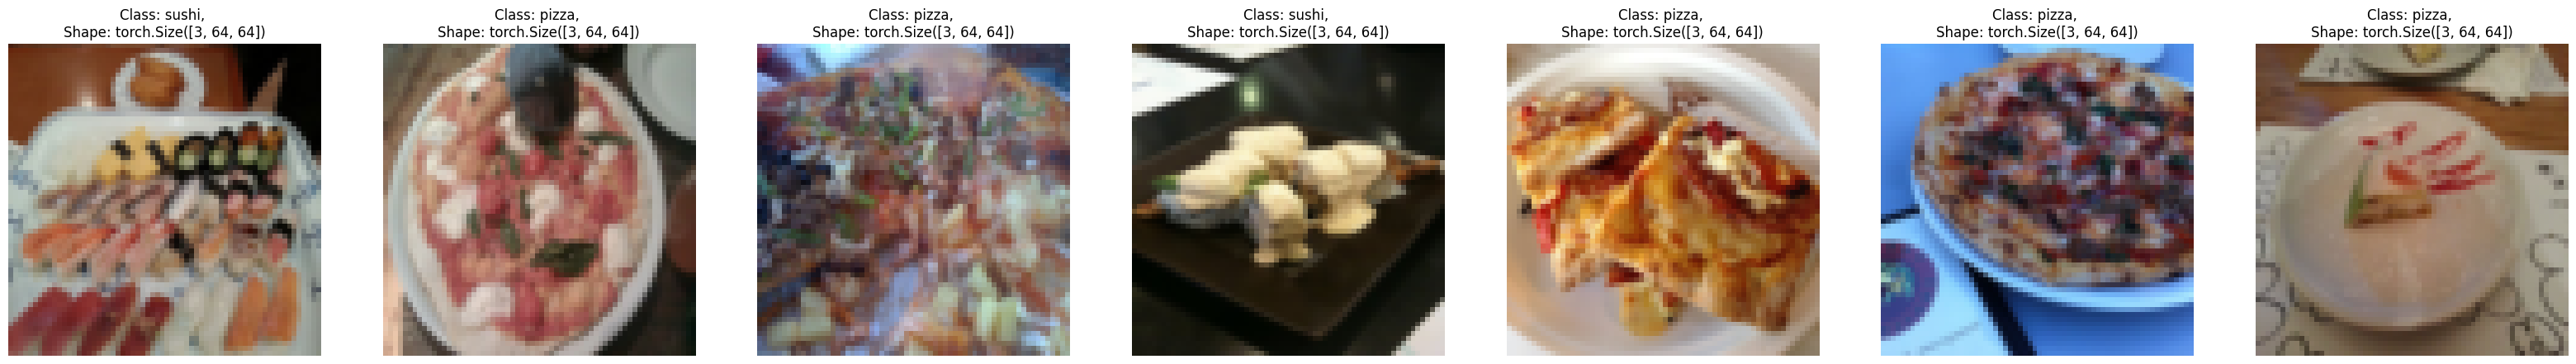

In [184]:
display_random_image(train_data_custom, n=7, seed=42, display_shape=True)

### 5.4 Turning our custom dataset into a DataLoader

In [185]:
from torch.utils.data import DataLoader

# Create train and test data loaders
BATCH_SIZE = 32

train_dataloader_custom = DataLoader(train_data_custom,
                                    batch_size=BATCH_SIZE,
                                    num_workers=2,
                                    shuffle=True)

test_dataloader_custom = DataLoader(test_data_custom,
                                    batch_size=BATCH_SIZE,
                                    num_workers=2,
                                    shuffle=False)

In [186]:
train_dataloader_custom, test_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x7eb52582a4e0>,
 <torch.utils.data.dataloader.DataLoader at 0x7eb5258802f0>)

In [187]:
# Get umage and label from the custom data loader
img, label = next(iter(train_dataloader_custom))

print(f"Image batch shape: {img.shape}")
print(f"Image label shape: {label.shape}")

Image batch shape: torch.Size([32, 3, 64, 64])
Image label shape: torch.Size([32])


## 6. Other from transforms

Data augmentation is a technique used to artificially increase the size of a training dataset by creating modified versions of existing data.  It's extremely useful in machine learning, particularly in situations where collecting more data is expensive, time-consuming, or difficult.  By expanding the dataset, data augmentation aims to improve the performance and generalization ability of machine learning models.

Here's a breakdown of key aspects of data augmentation:

**Why Use Data Augmentation?**

* **Increased Training Data:** More data often leads to better model performance, especially with deep learning models that are data-hungry.
* **Improved Generalization:**  Augmented data introduces variations that help the model learn to handle a wider range of inputs, making it more robust and less prone to overfitting (performing well on training data but poorly on unseen data).
* **Addressing Class Imbalance:** If some classes have significantly fewer examples than others, augmentation can help balance the dataset, preventing the model from being biased towards the majority class.
* **Reducing Overfitting:** By introducing variations, the model is less likely to memorize the training data and better able to generalize to new, unseen data.

**Common Data Augmentation Techniques:**

The specific techniques used depend on the type of data (images, text, audio, etc.).

**For Images:**

* **Geometric Transformations:**
    * **Rotation:** Rotating the image by a certain angle.
    * **Flipping:** Flipping the image horizontally or vertically.
    * **Cropping:** Randomly cropping sections of the image.
    * **Resizing:** Scaling the image up or down.
    * **Shearing:** Skewing the image.
* **Color Space Transformations:**
    * **Brightness:** Adjusting the brightness of the image.
    * **Contrast:** Modifying the contrast.
    * **Saturation:** Changing the saturation.
    * **Hue:** Shifting the hue.
* **Adding Noise:**
    * **Gaussian Noise:** Adding random Gaussian noise to the image.
    * **Salt and Pepper Noise:** Randomly changing pixels to black or white.
* **Random Erasing:** Randomly selecting rectangular regions in the image and erasing their pixels.
* **Mixing Images:** Combining two or more images, such as through blending or overlaying.
* **Advanced Techniques:**
    * **Generative Adversarial Networks (GANs):**  Can create entirely new, synthetic images.
    * **Neural Style Transfer:** Applying the style of one image to the content of another.


**For Text:**

* **Synonym Replacement:** Replacing words with their synonyms.
* **Back Translation:** Translating the text to another language and then back to the original language.
* **Random Insertion:** Inserting random words from the vocabulary.
* **Random Deletion:** Randomly deleting words from the text.
* **Random Swap:** Swapping two words in the text.


**For Audio:**

* **Changing Pitch:** Shifting the pitch of the audio up or down.
* **Changing Speed:** Increasing or decreasing the playback speed.
* **Adding Noise:** Adding background noise to the audio.
* **Time Stretching:** Stretching or compressing the audio in time without affecting the pitch.


**Key Considerations:**

* **Domain Knowledge:** Understanding the specific characteristics of your data is crucial for choosing appropriate augmentation techniques.  Augmentations should reflect realistic variations that might be encountered in real-world scenarios.
* **Over-Augmentation:** Applying too much augmentation can distort the data and hurt performance. It's essential to find a balance.
* **Computational Cost:** Some augmentation techniques can be computationally expensive, especially for large datasets.
* **Validation Set:**  Avoid applying augmentation to the validation set, as this can lead to overly optimistic performance estimates.  Augmentation should only be applied to the training data.


Data augmentation is a powerful tool that can significantly enhance the performance of machine learning models. By carefully selecting and applying appropriate techniques, you can improve generalization, robustness, and overall accuracy.


## 7. Model 0: Tiny VGG with custom dataset without data augmentation

### 7.1 Creating transforms and datasets for Model 0

In [188]:
# Simple transform
simple_tranform = transforms.Compose([
    transforms.ToImage(),
    transforms.Resize((64, 64)),
    transforms.ToDtype(torch.float32, scale=True),
    transforms.ToImage(),
])

In [189]:
# 1. Load and transform data
from torchvision import datasets
train_data_simple = datasets.ImageFolder(root=train_dir,
                                        transform=simple_tranform)

test_data_simple = datasets.ImageFolder(root=test_dir,
                                        transform=simple_tranform)

# 2. Turn data into DataLoader
from torch.utils.data import DataLoader

# Setup size of the batch and number of workers
BATCH_SIZE = 32
NUM_WORKERS = 2

# Create DataLoader
train_dataloader_simple = DataLoader(train_data_simple,
                                    batch_size=BATCH_SIZE,
                                    num_workers=NUM_WORKERS,
                                    shuffle=True)

test_dataloader_simple = DataLoader(test_data_simple,
                                    batch_size=BATCH_SIZE,
                                    num_workers=NUM_WORKERS,
                                    shuffle=False)

train_dataloader_simple, test_dataloader_simple


(<torch.utils.data.dataloader.DataLoader at 0x7eb529f408c0>,
 <torch.utils.data.dataloader.DataLoader at 0x7eb61c86f830>)

### 7.2 Create TinyVGG model

In [190]:
class TinyVGG(nn.Module):
    """A tiny VGG-like convolutional neural network.

    Args:
        nn (nn.Module): The PyTorch neural network module.
    """
    def __init__(self, input_shape: int,
                 hidden_units: int,
                 output_shape: int) -> None:
        super(TinyVGG, self).__init__()

        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units * 14 * 14,  # Adjusted input features
                      out_features=output_shape)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Forward pass of the neural network.

        Args:
            x (torch.Tensor): The input data.

        Returns:
            torch.Tensor: The output of the neural network.
        """
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.classifier(x)

        return x

In [191]:
# Setup the input shape, hidden units, and output shape
INPUT_SHAPE = 3
HIDDEN_UNITS = 64
OUTPUT_SHAPE = len(train_data.classes)

# Create an instance of the TinyVGG model
model_0 = TinyVGG(input_shape=INPUT_SHAPE,
                   hidden_units=HIDDEN_UNITS,
                   output_shape=OUTPUT_SHAPE)


model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=12544, out_features=3, bias=True)
  )
)

### 7.3 Try a forward pass with the TinyVGG model on a single image

In [332]:
# Setup the input shape, hidden units, and output shape
INPUT_SHAPE = 3
HIDDEN_UNITS = 64
OUTPUT_SHAPE = len(train_data.classes)

# Create an instance of the TinyVGG model
model_0 = TinyVGG(input_shape=INPUT_SHAPE,
                   hidden_units=HIDDEN_UNITS,
                   output_shape=OUTPUT_SHAPE)

# Get a single image batch
img, label = next(iter(train_dataloader_simple))

# Make a prediction
model_0(img)

tensor([[ 0.1336, -0.1635, -0.0641],
        [ 0.1411, -0.1006, -0.0684],
        [ 0.1724, -0.2140, -0.0507],
        [ 0.1158, -0.1434, -0.0309],
        [ 0.1201, -0.1880, -0.0679],
        [ 0.1121, -0.1710, -0.0378],
        [ 0.1450, -0.1529, -0.0574],
        [ 0.0951, -0.1407, -0.0283],
        [ 0.1680, -0.1646, -0.0308],
        [ 0.0876, -0.0581, -0.0721],
        [ 0.1425, -0.0907, -0.0755],
        [ 0.1562, -0.1245, -0.0614],
        [ 0.0590, -0.1488, -0.0740],
        [ 0.1012, -0.1484, -0.0464],
        [ 0.1430, -0.2001, -0.0698],
        [ 0.1515, -0.1671, -0.0761],
        [ 0.1052, -0.1544, -0.0718],
        [ 0.1287, -0.1504, -0.0645],
        [ 0.1986, -0.2006, -0.0594],
        [ 0.0832, -0.1086, -0.0348],
        [ 0.1131, -0.2067, -0.0555],
        [ 0.1163, -0.0948, -0.0470],
        [ 0.1076, -0.1466, -0.0586],
        [ 0.1794, -0.1677, -0.0552],
        [ 0.1205, -0.1862, -0.0747],
        [ 0.1581, -0.1170, -0.0425],
        [ 0.0990, -0.1192, -0.0534],
 

### 7.4 Using `torchsummary`to get the summary of the model

In [333]:
# Get the summary of the model
from torchinfo import summary

summary(model_0, input_size=(BATCH_SIZE, 3, 64, 64))

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [32, 3]                   --
├─Sequential: 1-1                        [32, 64, 31, 31]          --
│    └─Conv2d: 2-1                       [32, 64, 62, 62]          1,792
│    └─ReLU: 2-2                         [32, 64, 62, 62]          --
│    └─MaxPool2d: 2-3                    [32, 64, 31, 31]          --
├─Sequential: 1-2                        [32, 64, 14, 14]          --
│    └─Conv2d: 2-4                       [32, 64, 29, 29]          36,928
│    └─ReLU: 2-5                         [32, 64, 29, 29]          --
│    └─MaxPool2d: 2-6                    [32, 64, 14, 14]          --
├─Sequential: 1-3                        [32, 3]                   --
│    └─Flatten: 2-7                      [32, 12544]               --
│    └─Linear: 2-8                       [32, 3]                   37,635
Total params: 76,355
Trainable params: 76,355
Non-trainable params: 0
Tota

### 7.5 Creating training and testing loops functions

In [334]:
# Setup the loss function and optimizer
from torch import optim
from torchmetrics import Accuracy

# Setup the training loop

def training_loop(model: nn.Module,
                  dataloader: DataLoader,
                  loss_function: nn.Module,
                  optimizer: optim.Optimizer,
                  device=device) -> Tuple[float, float]:
    """Trains a PyTorch model.

    Args:
        model (nn.Module): A PyTorch neural network model.
        dataloader (DataLoader): A PyTorch DataLoader.
        loss_function (nn.Module): A PyTorch loss function.
        optimizer (optim.Optimizer): A PyTorch optimizer.
        num_epochs (int): The number of epochs.
        device (_type_, optional): The device to use. Defaults to device.

    Returns:
        Tuple[float, float]: A tuple containing the accuracy and loss.
    """

    # Send the model to the device
    model = model.to(device)
     
    # Set the model to training mode
    model.train()

    for batch, (images, labels) in enumerate(dataloader):
        # Send the data to the device
        images = images.to(device)
        labels = labels.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Make predictions
        predictions = model(images)

        # Calculate the loss
        loss = loss_function(predictions, labels)

        # Calculate the gradients
        loss.backward()

        # Update the weights
        optimizer.step()

        # Calculate accuracy metric
        accuracy = Accuracy(task="multiclass", num_classes=OUTPUT_SHAPE)
        accuracy.update(predictions, labels)
        accuracy(predictions, labels)

        return loss.item(), accuracy.compute()

In [335]:
# Create a function to evaluate the model
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_function: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:
    """Evaluates a PyTorch model.

    Args:
        model (torch.nn.Module): A PyTorch neural network model.
        dataloader (torch.utils.data.DataLoader): A PyTorch DataLoader.
        loss_function (torch.nn.Module): A PyTorch loss function.
        device (torch.device): A PyTorch device.

    Returns:
        Tuple[float, float]: A tuple containing the accuracy and loss.
    """
    model = model.to(device)
    model.eval()

    losses = []
    accuracies = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            predictions = model(images)
            loss = loss_function(predictions, labels)

            accuracy = Accuracy(task="multiclass", num_classes=OUTPUT_SHAPE)
            accuracy.update(predictions, labels)
            accuracy(predictions, labels)

            losses.append(loss.item())
            accuracies.append(accuracy.compute())

    return np.mean(losses), np.mean(accuracies)

### 7.6 Creating a `train` and `test` function

In [342]:
from tqdm.auto import tqdm

def train_model(model: nn.Module,
                train_dataloader: DataLoader,
                test_dataloader: DataLoader,
                optimizer: optim.Optimizer,
                loss_function: nn.Module,
                num_epochs: int,
                device: torch.device) -> Dict[str, List[float]]:
    """Trains a PyTorch model.

    Args:
        model (nn.Module): A PyTorch neural network model.
        train_dataloader (DataLoader): A PyTorch DataLoader.
        test_dataloader (DataLoader): A PyTorch DataLoader.
        optimizer (optim.Optimizer): A PyTorch optimizer.
        loss_function (nn.Module): A PyTorch loss function.
        num_epochs (int): The number of epochs.
        device (torch.device): The device to use.

    Returns:
        Dict[str, List[float]]: A dictionary containing the training and testing results
    """
    
    train_losses, test_losses, train_accuracies, test_accuracies = [], [], [], []

    results = {"train_loss": [], "test_loss": [], "train_accuracy": [], "test_accuracy": []}

    for epoch in tqdm(range(num_epochs)):
        print(f"Epoch {epoch + 1}\n-------------------------------")
        train_loss, train_accuracy = training_loop(model, train_dataloader, loss_function, optimizer, device)
        test_loss, test_accuracy = test_step(model, test_dataloader, loss_function, device)

        print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
        print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")
        print()

        results["train_loss"].append(train_loss)
        results["test_loss"].append(test_loss)
        results["train_accuracy"].append(train_accuracy)
        results["test_accuracy"].append(test_accuracy)

    return results

### 7.7 Train and evaluate the model

In [343]:
# Setup the parameters for training
from torch import optim

# Number of epochs
NUM_EPOCHS = 50

# Loss function
loss_function = nn.CrossEntropyLoss()

# Optimizer
optimizer = optim.Adam(params=model_0.parameters(),
                       lr=0.001)

# Start the timer
from timeit import default_timer as timer
start_time_model_0 = timer()

# Train the model
results_model_0 = train_model(model_0,
                              train_dataloader_simple,
                              test_dataloader_simple,
                              optimizer,
                              loss_function,
                              NUM_EPOCHS,
                              device)

# End the timer
end_time_model_0 = timer()
print(f"Training time: {end_time_model_0 - start_time_model_0:.4f} seconds")



  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1
-------------------------------


  2%|▏         | 1/50 [00:00<00:25,  1.90it/s]

Train Loss: 1.0782, Train Accuracy: 0.4062
Test Loss: 1.0960, Test Accuracy: 0.5417

Epoch 2
-------------------------------


  4%|▍         | 2/50 [00:01<00:25,  1.87it/s]

Train Loss: 1.1845, Train Accuracy: 0.4688
Test Loss: 0.9967, Test Accuracy: 0.5417

Epoch 3
-------------------------------


  6%|▌         | 3/50 [00:01<00:24,  1.92it/s]

Train Loss: 1.2123, Train Accuracy: 0.2500
Test Loss: 1.0874, Test Accuracy: 0.2604

Epoch 4
-------------------------------


  8%|▊         | 4/50 [00:02<00:24,  1.87it/s]

Train Loss: 1.0916, Train Accuracy: 0.3125
Test Loss: 1.1465, Test Accuracy: 0.2812

Epoch 5
-------------------------------


 10%|█         | 5/50 [00:02<00:23,  1.88it/s]

Train Loss: 1.0756, Train Accuracy: 0.4688
Test Loss: 1.1455, Test Accuracy: 0.1979

Epoch 6
-------------------------------


 12%|█▏        | 6/50 [00:03<00:23,  1.83it/s]

Train Loss: 1.1437, Train Accuracy: 0.1875
Test Loss: 1.0889, Test Accuracy: 0.2386

Epoch 7
-------------------------------


 14%|█▍        | 7/50 [00:03<00:23,  1.82it/s]

Train Loss: 1.0575, Train Accuracy: 0.4375
Test Loss: 1.0617, Test Accuracy: 0.5331

Epoch 8
-------------------------------


 16%|█▌        | 8/50 [00:04<00:23,  1.78it/s]

Train Loss: 1.0642, Train Accuracy: 0.4688
Test Loss: 1.0552, Test Accuracy: 0.5047

Epoch 9
-------------------------------


 18%|█▊        | 9/50 [00:04<00:22,  1.86it/s]

Train Loss: 1.0270, Train Accuracy: 0.6562
Test Loss: 1.0627, Test Accuracy: 0.5047

Epoch 10
-------------------------------


 20%|██        | 10/50 [00:05<00:21,  1.88it/s]

Train Loss: 1.0213, Train Accuracy: 0.6250
Test Loss: 1.0692, Test Accuracy: 0.4640

Epoch 11
-------------------------------


 22%|██▏       | 11/50 [00:05<00:20,  1.86it/s]

Train Loss: 1.0127, Train Accuracy: 0.5938
Test Loss: 1.0693, Test Accuracy: 0.4129

Epoch 12
-------------------------------


 24%|██▍       | 12/50 [00:06<00:20,  1.85it/s]

Train Loss: 0.9275, Train Accuracy: 0.7500
Test Loss: 1.0866, Test Accuracy: 0.3722

Epoch 13
-------------------------------


 26%|██▌       | 13/50 [00:07<00:20,  1.82it/s]

Train Loss: 0.9596, Train Accuracy: 0.6875
Test Loss: 1.0996, Test Accuracy: 0.3116

Epoch 14
-------------------------------


 28%|██▊       | 14/50 [00:07<00:20,  1.79it/s]

Train Loss: 0.9138, Train Accuracy: 0.5312
Test Loss: 1.0735, Test Accuracy: 0.4233

Epoch 15
-------------------------------


 30%|███       | 15/50 [00:08<00:19,  1.82it/s]

Train Loss: 0.7953, Train Accuracy: 0.6875
Test Loss: 1.1207, Test Accuracy: 0.3930

Epoch 16
-------------------------------


 32%|███▏      | 16/50 [00:08<00:18,  1.81it/s]

Train Loss: 0.9106, Train Accuracy: 0.5938
Test Loss: 1.1448, Test Accuracy: 0.4337

Epoch 17
-------------------------------


 34%|███▍      | 17/50 [00:09<00:18,  1.82it/s]

Train Loss: 0.9531, Train Accuracy: 0.5938
Test Loss: 1.1003, Test Accuracy: 0.4536

Epoch 18
-------------------------------


 36%|███▌      | 18/50 [00:09<00:17,  1.83it/s]

Train Loss: 0.9002, Train Accuracy: 0.5312
Test Loss: 1.0612, Test Accuracy: 0.5152

Epoch 19
-------------------------------


 38%|███▊      | 19/50 [00:10<00:17,  1.75it/s]

Train Loss: 0.8457, Train Accuracy: 0.6562
Test Loss: 1.0944, Test Accuracy: 0.4025

Epoch 20
-------------------------------


 40%|████      | 20/50 [00:10<00:16,  1.80it/s]

Train Loss: 0.8514, Train Accuracy: 0.7812
Test Loss: 1.2236, Test Accuracy: 0.3523

Epoch 21
-------------------------------


 42%|████▏     | 21/50 [00:11<00:16,  1.80it/s]

Train Loss: 0.6718, Train Accuracy: 0.7500
Test Loss: 1.3868, Test Accuracy: 0.3125

Epoch 22
-------------------------------


 44%|████▍     | 22/50 [00:12<00:15,  1.80it/s]

Train Loss: 0.9153, Train Accuracy: 0.5625
Test Loss: 1.2649, Test Accuracy: 0.3428

Epoch 23
-------------------------------


 46%|████▌     | 23/50 [00:12<00:14,  1.80it/s]

Train Loss: 0.7510, Train Accuracy: 0.6562
Test Loss: 1.2394, Test Accuracy: 0.3021

Epoch 24
-------------------------------


 48%|████▊     | 24/50 [00:13<00:14,  1.84it/s]

Train Loss: 0.8784, Train Accuracy: 0.5312
Test Loss: 1.1303, Test Accuracy: 0.3627

Epoch 25
-------------------------------


 50%|█████     | 25/50 [00:13<00:13,  1.82it/s]

Train Loss: 0.7479, Train Accuracy: 0.6250
Test Loss: 1.0358, Test Accuracy: 0.4848

Epoch 26
-------------------------------


 52%|█████▏    | 26/50 [00:14<00:12,  1.85it/s]

Train Loss: 0.8363, Train Accuracy: 0.6250
Test Loss: 0.9540, Test Accuracy: 0.5350

Epoch 27
-------------------------------


 54%|█████▍    | 27/50 [00:14<00:12,  1.82it/s]

Train Loss: 0.7447, Train Accuracy: 0.6250
Test Loss: 0.9311, Test Accuracy: 0.5455

Epoch 28
-------------------------------


 56%|█████▌    | 28/50 [00:15<00:12,  1.82it/s]

Train Loss: 0.8445, Train Accuracy: 0.6250
Test Loss: 0.9535, Test Accuracy: 0.5464

Epoch 29
-------------------------------


 58%|█████▊    | 29/50 [00:15<00:11,  1.84it/s]

Train Loss: 0.7730, Train Accuracy: 0.6875
Test Loss: 1.0169, Test Accuracy: 0.4848

Epoch 30
-------------------------------


 60%|██████    | 30/50 [00:16<00:10,  1.86it/s]

Train Loss: 0.6816, Train Accuracy: 0.7188
Test Loss: 1.0401, Test Accuracy: 0.4848

Epoch 31
-------------------------------


 62%|██████▏   | 31/50 [00:16<00:10,  1.86it/s]

Train Loss: 0.9614, Train Accuracy: 0.5000
Test Loss: 1.0509, Test Accuracy: 0.4848

Epoch 32
-------------------------------


 64%|██████▍   | 32/50 [00:17<00:09,  1.86it/s]

Train Loss: 0.8390, Train Accuracy: 0.5625
Test Loss: 0.9978, Test Accuracy: 0.4848

Epoch 33
-------------------------------


 66%|██████▌   | 33/50 [00:18<00:09,  1.83it/s]

Train Loss: 0.8304, Train Accuracy: 0.6875
Test Loss: 0.9400, Test Accuracy: 0.5464

Epoch 34
-------------------------------


 68%|██████▊   | 34/50 [00:18<00:08,  1.83it/s]

Train Loss: 0.8732, Train Accuracy: 0.5625
Test Loss: 0.9217, Test Accuracy: 0.5767

Epoch 35
-------------------------------


 70%|███████   | 35/50 [00:19<00:08,  1.83it/s]

Train Loss: 0.6579, Train Accuracy: 0.7812
Test Loss: 0.9400, Test Accuracy: 0.5246

Epoch 36
-------------------------------


 72%|███████▏  | 36/50 [00:19<00:07,  1.78it/s]

Train Loss: 0.7786, Train Accuracy: 0.6875
Test Loss: 0.9756, Test Accuracy: 0.5767

Epoch 37
-------------------------------


 74%|███████▍  | 37/50 [00:20<00:07,  1.77it/s]

Train Loss: 0.8643, Train Accuracy: 0.6875
Test Loss: 1.0155, Test Accuracy: 0.4848

Epoch 38
-------------------------------


 76%|███████▌  | 38/50 [00:20<00:06,  1.81it/s]

Train Loss: 0.9656, Train Accuracy: 0.6250
Test Loss: 1.0487, Test Accuracy: 0.4953

Epoch 39
-------------------------------


 78%|███████▊  | 39/50 [00:21<00:06,  1.83it/s]

Train Loss: 0.6708, Train Accuracy: 0.7500
Test Loss: 1.1149, Test Accuracy: 0.4650

Epoch 40
-------------------------------


 80%|████████  | 40/50 [00:21<00:05,  1.82it/s]

Train Loss: 0.8187, Train Accuracy: 0.5312
Test Loss: 1.1127, Test Accuracy: 0.4242

Epoch 41
-------------------------------


 82%|████████▏ | 41/50 [00:22<00:04,  1.82it/s]

Train Loss: 0.8122, Train Accuracy: 0.5938
Test Loss: 1.0701, Test Accuracy: 0.4953

Epoch 42
-------------------------------


 84%|████████▍ | 42/50 [00:22<00:04,  1.88it/s]

Train Loss: 0.8307, Train Accuracy: 0.5625
Test Loss: 0.9873, Test Accuracy: 0.4953

Epoch 43
-------------------------------


 86%|████████▌ | 43/50 [00:23<00:03,  1.87it/s]

Train Loss: 0.6525, Train Accuracy: 0.7188
Test Loss: 0.9195, Test Accuracy: 0.5464

Epoch 44
-------------------------------


 88%|████████▊ | 44/50 [00:23<00:03,  1.90it/s]

Train Loss: 0.8271, Train Accuracy: 0.5938
Test Loss: 0.8988, Test Accuracy: 0.6165

Epoch 45
-------------------------------


 90%|█████████ | 45/50 [00:24<00:02,  1.89it/s]

Train Loss: 0.5703, Train Accuracy: 0.7500
Test Loss: 0.8904, Test Accuracy: 0.5852

Epoch 46
-------------------------------


 92%|█████████▏| 46/50 [00:25<00:02,  1.91it/s]

Train Loss: 0.7368, Train Accuracy: 0.7188
Test Loss: 0.8908, Test Accuracy: 0.5852

Epoch 47
-------------------------------


 94%|█████████▍| 47/50 [00:25<00:01,  1.88it/s]

Train Loss: 0.7868, Train Accuracy: 0.7188
Test Loss: 0.9029, Test Accuracy: 0.6070

Epoch 48
-------------------------------


 96%|█████████▌| 48/50 [00:26<00:01,  1.89it/s]

Train Loss: 0.6669, Train Accuracy: 0.8438
Test Loss: 0.9329, Test Accuracy: 0.4953

Epoch 49
-------------------------------


 98%|█████████▊| 49/50 [00:26<00:00,  1.84it/s]

Train Loss: 0.6312, Train Accuracy: 0.9062
Test Loss: 0.9786, Test Accuracy: 0.4848

Epoch 50
-------------------------------


100%|██████████| 50/50 [00:27<00:00,  1.84it/s]

Train Loss: 0.5991, Train Accuracy: 0.7812
Test Loss: 1.0192, Test Accuracy: 0.4650

Training time: 27.2273 seconds


### 7.8 Plot the loss curves and accuracy

In [344]:
results_model_0

{'train_loss': [1.078208327293396,
  1.1844549179077148,
  1.2123371362686157,
  1.091647744178772,
  1.075623869895935,
  1.143706202507019,
  1.0574772357940674,
  1.0641661882400513,
  1.0269947052001953,
  1.021308422088623,
  1.0126603841781616,
  0.9275386333465576,
  0.9596427083015442,
  0.9137799739837646,
  0.7952795028686523,
  0.9105610847473145,
  0.9531338214874268,
  0.9002378582954407,
  0.845738410949707,
  0.8513663411140442,
  0.6717628240585327,
  0.9153074622154236,
  0.7510062456130981,
  0.8783937096595764,
  0.747854471206665,
  0.8363133668899536,
  0.744685709476471,
  0.8444960713386536,
  0.7729605436325073,
  0.6816496849060059,
  0.9613914489746094,
  0.8389673233032227,
  0.8303961753845215,
  0.8732432723045349,
  0.6579320430755615,
  0.7785581350326538,
  0.8643330931663513,
  0.9656438231468201,
  0.6708227396011353,
  0.8186787366867065,
  0.8122092485427856,
  0.8306651711463928,
  0.6524567008018494,
  0.8270589113235474,
  0.5702897906303406,
  0.

In [345]:
# Plot the results

def plot_results(results: Dict[str, List[float]]) -> None:
    """Plots the results of a PyTorch model.

    Args:
        results (Dict[str, List[float]]): A dictionary containing the results.
    """
    # Get the loss values of the results dictionary (train and test)
    train_loss = results["train_loss"]
    test_loss = results["test_loss"]

    # Get the accuracy values of the results dictionary (train and test)
    train_accuracy = results["train_accuracy"]
    test_accuracy = results["test_accuracy"]

    # Create a range of the number of epochs
    epochs = range(len(train_loss))


    # Create a figure and axis
    fig, axs = plt.subplots(2, 1, figsize=(12, 8))

    # Plot the loss values
    axs[0].plot(epochs, train_loss, label="Train Loss", color="blue", marker="o")
    axs[0].plot(epochs, test_loss, label="Test Loss", color="red", marker="o")
    axs[0].set_title("Loss vs. Number of Epochs")
    axs[0].set_xlabel("Epochs")
    axs[0].set_ylabel("Loss")
    axs[0].legend()

    # Plot the accuracy values
    axs[1].plot(epochs, train_accuracy, label="Train Accuracy", color="blue", marker="o")
    axs[1].plot(epochs, test_accuracy, label="Test Accuracy", color="red", marker="o")
    axs[1].set_title("Accuracy vs. Number of Epochs")
    axs[1].set_xlabel("Epochs")
    axs[1].set_ylabel("Accuracy")
    axs[1].legend()

    plt.tight_layout()
    plt.show()
    

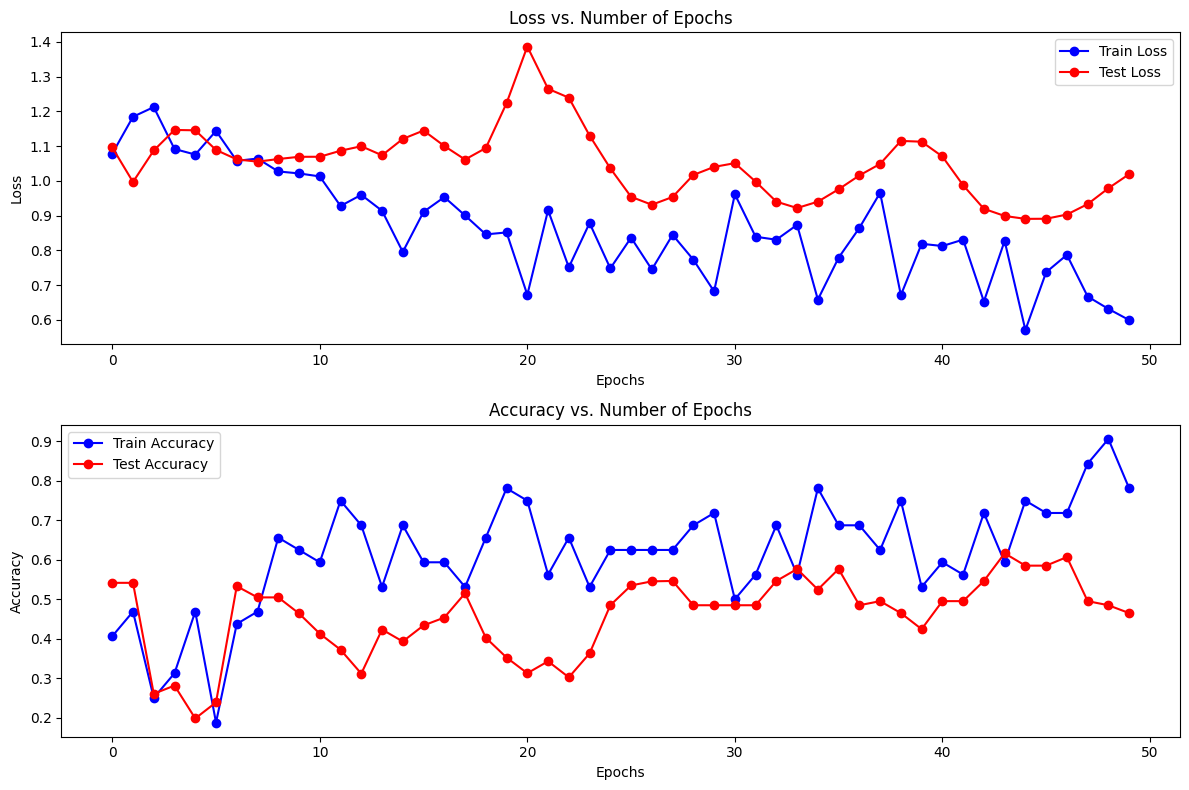

In [346]:
plot_results(results_model_0)

## 8. What should an ideal loss cuve look like?

An ideal loss curve in PyTorch (or any deep learning framework) during training should generally show a consistent decrease in loss over epochs, eventually plateauing.  Here's how it relates to overfitting, underfitting, and a good fit:

* **Good Fit (Ideal Scenario):**  The loss steadily decreases during the initial epochs, showing the model is learning the patterns in the training data.  The rate of decrease gradually slows down, and the loss eventually plateaus at a relatively low value.  This indicates that the model has learned the generalizable features of the data without overfitting.  The validation loss should also decrease and ideally plateau at a similar level to the training loss, indicating good generalization.

* **Overfitting:** The training loss continues to decrease significantly, potentially reaching very low values. However, the validation loss starts to increase or fluctuates erratically after a certain point.  This divergence between training and validation loss is a classic sign of overfitting. The model has learned the training data too well, including its noise and specificities, and is unable to generalize to unseen data.

* **Underfitting:** Both the training loss and the validation loss remain relatively high and don't decrease much during training. The model is too simple to capture the underlying patterns in the data. It neither learns the training data effectively nor generalizes well to the validation set. The loss curves might plateau early at a high value.

In summary, a good fit is indicated by a decreasing training loss that plateaus at a reasonable level, coupled with a validation loss that follows a similar trend and doesn't increase significantly. Overfitting shows a large gap between a low training loss and a high validation loss. Underfitting is characterized by high values for both training and validation losses.  Visualizing these curves is crucial for diagnosing training issues and adjusting model architecture or training parameters accordingly.


## 9. Model 1: TinyVGG with Data Augmentation

### 9.1 Create transform with data augmentation

In [347]:
print(test_data_simple)

Dataset ImageFolder
    Number of datapoints: 75
    Root location: data/images/test
    StandardTransform
Transform: Compose(
                 ToImage()
                 Resize(size=[64, 64], interpolation=InterpolationMode.BILINEAR, antialias=True)
                 ToDtype(scale=True)
                 ToImage()
           )


In [348]:
# Create training transforms with data augmentation
from torchvision.transforms import v2 as transforms

train_transforms_augmented = transforms.Compose([
    transforms.ToImage(),
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.ToDtype(torch.float32, scale=True),
    transforms.ToImage(),
])

test_tranforms_augmented = transforms.Compose([
    transforms.ToImage(),
    transforms.Resize((64, 64)),
    transforms.ToDtype(torch.float32, scale=True),
    transforms.ToImage()
])

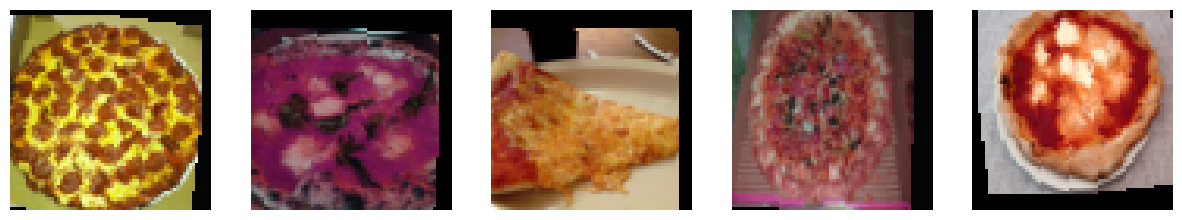

In [349]:
# Plot transformed images
plot_transformed_images(train_image_paths, train_transforms_augmented)

### 9.2 Create train and test `Dataset`'s and `DataLoader`'s with data augmented

In [350]:
# Turn image data into PyTorch datasets
from torchvision import datasets
train_data_augmented = datasets.ImageFolder(root=train_dir,
                                            transform=train_transforms_augmented)

test_data_augmented = datasets.ImageFolder(root=test_dir,
                                             transform=test_tranforms_augmented)

In [351]:

# Create DataLoader
import os
from torch.utils.data import DataLoader

BATCH_SIZE = 32
NUM_WORKERS = 2

train_dataloader_augmented = DataLoader(train_data_augmented,
                                        batch_size=BATCH_SIZE,
                                        num_workers=NUM_WORKERS,
                                        shuffle=True)

test_dataloader_augmented = DataLoader(test_data_augmented,
                                        batch_size=BATCH_SIZE,
                                        num_workers=NUM_WORKERS,
                                        shuffle=False)

train_dataloader_augmented, test_dataloader_augmented

(<torch.utils.data.dataloader.DataLoader at 0x7eb521f7f0e0>,
 <torch.utils.data.dataloader.DataLoader at 0x7eb521f7f980>)

### 9.3 Construct and train model 1

In [352]:
# Create model_1 with augmented data

model_1 = TinyVGG(input_shape=INPUT_SHAPE,
                  hidden_units=HIDDEN_UNITS,
                  output_shape=OUTPUT_SHAPE)

model_1

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=12544, out_features=3, bias=True)
  )
)

In [353]:
print(train_data_augmented, train_data_simple)

Dataset ImageFolder
    Number of datapoints: 225
    Root location: data/images/train
    StandardTransform
Transform: Compose(
                 ToImage()
                 Resize(size=[64, 64], interpolation=InterpolationMode.BILINEAR, antialias=True)
                 RandomHorizontalFlip(p=0.5)
                 RandomRotation(degrees=[-10.0, 10.0], interpolation=InterpolationMode.NEAREST, expand=False, fill=0)
                 RandomAffine(degrees=[0.0, 0.0], translate=(0.1, 0.1), interpolation=InterpolationMode.NEAREST, fill=0)
                 ColorJitter(brightness=(0.9, 1.1), contrast=(0.9, 1.1), saturation=(0.9, 1.1), hue=(-0.1, 0.1))
                 ToDtype(scale=True)
                 ToImage()
           ) Dataset ImageFolder
    Number of datapoints: 225
    Root location: data/images/train
    StandardTransform
Transform: Compose(
                 ToImage()
                 Resize(size=[64, 64], interpolation=InterpolationMode.BILINEAR, antialias=True)
                 ToD

In [354]:
# Set  the number of epochs
NUM_EPOCHS = 50

# Setup the loss function and optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(params=model_1.parameters(),
                       lr=0.001)

# Start the timer
from timeit import default_timer as timer
start_time_model_1 = timer()

# Train the model
results_model_1 = train_model(model_1,
                              train_dataloader_augmented,
                              test_dataloader_augmented,
                              optimizer,
                              loss_function,
                              NUM_EPOCHS,
                              device)

# End the timer
end_time_model_1 = timer()
print(f"Training time: {end_time_model_1 - start_time_model_1:.4f} seconds")

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1
-------------------------------


  2%|▏         | 1/50 [00:00<00:31,  1.54it/s]

Train Loss: 1.1049, Train Accuracy: 0.3750
Test Loss: 1.6852, Test Accuracy: 0.2500

Epoch 2
-------------------------------


  4%|▍         | 2/50 [00:01<00:29,  1.63it/s]

Train Loss: 1.1217, Train Accuracy: 0.5938
Test Loss: 1.4940, Test Accuracy: 0.1979

Epoch 3
-------------------------------


  6%|▌         | 3/50 [00:01<00:29,  1.61it/s]

Train Loss: 1.0534, Train Accuracy: 0.4688
Test Loss: 1.2712, Test Accuracy: 0.1979

Epoch 4
-------------------------------


  8%|▊         | 4/50 [00:02<00:27,  1.65it/s]

Train Loss: 1.1671, Train Accuracy: 0.2500
Test Loss: 1.1169, Test Accuracy: 0.2917

Epoch 5
-------------------------------


 10%|█         | 5/50 [00:03<00:27,  1.65it/s]

Train Loss: 1.0712, Train Accuracy: 0.5625
Test Loss: 1.0525, Test Accuracy: 0.4318

Epoch 6
-------------------------------


 12%|█▏        | 6/50 [00:03<00:26,  1.67it/s]

Train Loss: 1.0632, Train Accuracy: 0.3750
Test Loss: 1.0255, Test Accuracy: 0.4318

Epoch 7
-------------------------------


 14%|█▍        | 7/50 [00:04<00:25,  1.67it/s]

Train Loss: 1.1107, Train Accuracy: 0.4375
Test Loss: 1.0103, Test Accuracy: 0.5114

Epoch 8
-------------------------------


 16%|█▌        | 8/50 [00:04<00:25,  1.68it/s]

Train Loss: 1.1046, Train Accuracy: 0.3125
Test Loss: 1.0088, Test Accuracy: 0.5417

Epoch 9
-------------------------------


 18%|█▊        | 9/50 [00:05<00:24,  1.66it/s]

Train Loss: 1.0508, Train Accuracy: 0.4062
Test Loss: 1.0132, Test Accuracy: 0.5729

Epoch 10
-------------------------------


 20%|██        | 10/50 [00:05<00:23,  1.71it/s]

Train Loss: 1.0441, Train Accuracy: 0.4062
Test Loss: 1.0161, Test Accuracy: 0.5038

Epoch 11
-------------------------------


 22%|██▏       | 11/50 [00:06<00:22,  1.72it/s]

Train Loss: 1.0183, Train Accuracy: 0.5000
Test Loss: 1.0228, Test Accuracy: 0.4432

Epoch 12
-------------------------------


 24%|██▍       | 12/50 [00:07<00:22,  1.72it/s]

Train Loss: 0.9957, Train Accuracy: 0.5625
Test Loss: 1.0348, Test Accuracy: 0.4328

Epoch 13
-------------------------------


 26%|██▌       | 13/50 [00:07<00:21,  1.70it/s]

Train Loss: 0.9748, Train Accuracy: 0.6250
Test Loss: 1.0287, Test Accuracy: 0.4432

Epoch 14
-------------------------------


 28%|██▊       | 14/50 [00:08<00:21,  1.66it/s]

Train Loss: 0.9798, Train Accuracy: 0.6250
Test Loss: 1.0215, Test Accuracy: 0.4432

Epoch 15
-------------------------------


 30%|███       | 15/50 [00:08<00:20,  1.68it/s]

Train Loss: 0.9138, Train Accuracy: 0.5625
Test Loss: 1.0406, Test Accuracy: 0.4223

Epoch 16
-------------------------------


 32%|███▏      | 16/50 [00:09<00:19,  1.71it/s]

Train Loss: 0.9303, Train Accuracy: 0.5625
Test Loss: 1.0884, Test Accuracy: 0.3731

Epoch 17
-------------------------------


 34%|███▍      | 17/50 [00:10<00:19,  1.67it/s]

Train Loss: 0.9302, Train Accuracy: 0.5312
Test Loss: 1.0676, Test Accuracy: 0.3826

Epoch 18
-------------------------------


 36%|███▌      | 18/50 [00:10<00:19,  1.65it/s]

Train Loss: 1.0192, Train Accuracy: 0.5312
Test Loss: 1.0555, Test Accuracy: 0.4119

Epoch 19
-------------------------------


 38%|███▊      | 19/50 [00:11<00:18,  1.64it/s]

Train Loss: 0.9829, Train Accuracy: 0.5000
Test Loss: 1.1076, Test Accuracy: 0.4242

Epoch 20
-------------------------------


 40%|████      | 20/50 [00:12<00:18,  1.63it/s]

Train Loss: 1.1110, Train Accuracy: 0.4688
Test Loss: 1.1356, Test Accuracy: 0.3939

Epoch 21
-------------------------------


 42%|████▏     | 21/50 [00:12<00:17,  1.66it/s]

Train Loss: 0.9195, Train Accuracy: 0.5938
Test Loss: 1.1336, Test Accuracy: 0.3939

Epoch 22
-------------------------------


 44%|████▍     | 22/50 [00:13<00:16,  1.67it/s]

Train Loss: 0.9030, Train Accuracy: 0.5312
Test Loss: 1.0789, Test Accuracy: 0.4650

Epoch 23
-------------------------------


 46%|████▌     | 23/50 [00:13<00:16,  1.64it/s]

Train Loss: 0.8851, Train Accuracy: 0.5312
Test Loss: 1.0167, Test Accuracy: 0.4328

Epoch 24
-------------------------------


 48%|████▊     | 24/50 [00:14<00:15,  1.65it/s]

Train Loss: 0.8896, Train Accuracy: 0.5625
Test Loss: 1.0175, Test Accuracy: 0.4650

Epoch 25
-------------------------------


 50%|█████     | 25/50 [00:14<00:14,  1.68it/s]

Train Loss: 0.8436, Train Accuracy: 0.5625
Test Loss: 1.0444, Test Accuracy: 0.5360

Epoch 26
-------------------------------


 52%|█████▏    | 26/50 [00:15<00:14,  1.68it/s]

Train Loss: 0.8371, Train Accuracy: 0.6562
Test Loss: 1.0623, Test Accuracy: 0.4337

Epoch 27
-------------------------------


 54%|█████▍    | 27/50 [00:16<00:13,  1.70it/s]

Train Loss: 1.0909, Train Accuracy: 0.4375
Test Loss: 1.0328, Test Accuracy: 0.5360

Epoch 28
-------------------------------


 56%|█████▌    | 28/50 [00:16<00:13,  1.66it/s]

Train Loss: 0.9276, Train Accuracy: 0.6562
Test Loss: 1.0088, Test Accuracy: 0.4754

Epoch 29
-------------------------------


 58%|█████▊    | 29/50 [00:17<00:12,  1.69it/s]

Train Loss: 0.9282, Train Accuracy: 0.6875
Test Loss: 1.0035, Test Accuracy: 0.4536

Epoch 30
-------------------------------


 60%|██████    | 30/50 [00:18<00:12,  1.64it/s]

Train Loss: 0.8989, Train Accuracy: 0.5312
Test Loss: 1.0070, Test Accuracy: 0.4640

Epoch 31
-------------------------------


 62%|██████▏   | 31/50 [00:18<00:11,  1.62it/s]

Train Loss: 0.8422, Train Accuracy: 0.6875
Test Loss: 1.0489, Test Accuracy: 0.4640

Epoch 32
-------------------------------


 64%|██████▍   | 32/50 [00:19<00:11,  1.63it/s]

Train Loss: 0.9188, Train Accuracy: 0.5625
Test Loss: 1.0795, Test Accuracy: 0.4650

Epoch 33
-------------------------------


 66%|██████▌   | 33/50 [00:19<00:10,  1.64it/s]

Train Loss: 0.8248, Train Accuracy: 0.6562
Test Loss: 1.1442, Test Accuracy: 0.4441

Epoch 34
-------------------------------


 68%|██████▊   | 34/50 [00:20<00:09,  1.63it/s]

Train Loss: 0.9646, Train Accuracy: 0.4688
Test Loss: 1.1898, Test Accuracy: 0.4138

Epoch 35
-------------------------------


 70%|███████   | 35/50 [00:21<00:08,  1.67it/s]

Train Loss: 1.0391, Train Accuracy: 0.4375
Test Loss: 1.1926, Test Accuracy: 0.4138

Epoch 36
-------------------------------


 72%|███████▏  | 36/50 [00:21<00:08,  1.67it/s]

Train Loss: 1.0363, Train Accuracy: 0.5625
Test Loss: 1.1307, Test Accuracy: 0.4242

Epoch 37
-------------------------------


 74%|███████▍  | 37/50 [00:22<00:07,  1.70it/s]

Train Loss: 0.9914, Train Accuracy: 0.4688
Test Loss: 1.0763, Test Accuracy: 0.4545

Epoch 38
-------------------------------


 76%|███████▌  | 38/50 [00:22<00:07,  1.70it/s]

Train Loss: 0.8243, Train Accuracy: 0.6250
Test Loss: 1.0365, Test Accuracy: 0.4650

Epoch 39
-------------------------------


 78%|███████▊  | 39/50 [00:23<00:06,  1.68it/s]

Train Loss: 0.9905, Train Accuracy: 0.4688
Test Loss: 0.9989, Test Accuracy: 0.4744

Epoch 40
-------------------------------


 80%|████████  | 40/50 [00:24<00:05,  1.68it/s]

Train Loss: 0.8672, Train Accuracy: 0.5938
Test Loss: 0.9919, Test Accuracy: 0.5057

Epoch 41
-------------------------------


 82%|████████▏ | 41/50 [00:24<00:05,  1.68it/s]

Train Loss: 0.8790, Train Accuracy: 0.5938
Test Loss: 1.0021, Test Accuracy: 0.4962

Epoch 42
-------------------------------


 84%|████████▍ | 42/50 [00:25<00:04,  1.65it/s]

Train Loss: 0.8697, Train Accuracy: 0.6562
Test Loss: 1.0192, Test Accuracy: 0.4858

Epoch 43
-------------------------------


 86%|████████▌ | 43/50 [00:25<00:04,  1.62it/s]

Train Loss: 0.7716, Train Accuracy: 0.6875
Test Loss: 1.0282, Test Accuracy: 0.4754

Epoch 44
-------------------------------


 88%|████████▊ | 44/50 [00:26<00:03,  1.61it/s]

Train Loss: 0.8382, Train Accuracy: 0.5000
Test Loss: 1.0479, Test Accuracy: 0.4337

Epoch 45
-------------------------------


 90%|█████████ | 45/50 [00:27<00:03,  1.58it/s]

Train Loss: 0.9063, Train Accuracy: 0.5312
Test Loss: 1.0571, Test Accuracy: 0.4233

Epoch 46
-------------------------------


 92%|█████████▏| 46/50 [00:27<00:02,  1.57it/s]

Train Loss: 0.7784, Train Accuracy: 0.6562
Test Loss: 1.0559, Test Accuracy: 0.4233

Epoch 47
-------------------------------


 94%|█████████▍| 47/50 [00:28<00:01,  1.54it/s]

Train Loss: 1.1389, Train Accuracy: 0.5312
Test Loss: 1.0283, Test Accuracy: 0.4536

Epoch 48
-------------------------------


 96%|█████████▌| 48/50 [00:29<00:01,  1.55it/s]

Train Loss: 1.0042, Train Accuracy: 0.3750
Test Loss: 0.9922, Test Accuracy: 0.5559

Epoch 49
-------------------------------


 98%|█████████▊| 49/50 [00:29<00:00,  1.57it/s]

Train Loss: 0.8153, Train Accuracy: 0.5625
Test Loss: 0.9680, Test Accuracy: 0.5663

Epoch 50
-------------------------------


100%|██████████| 50/50 [00:30<00:00,  1.65it/s]

Train Loss: 0.9758, Train Accuracy: 0.5000
Test Loss: 0.9561, Test Accuracy: 0.5672

Training time: 30.3490 seconds


### 9.4 Plot the loss and accuracy of the model

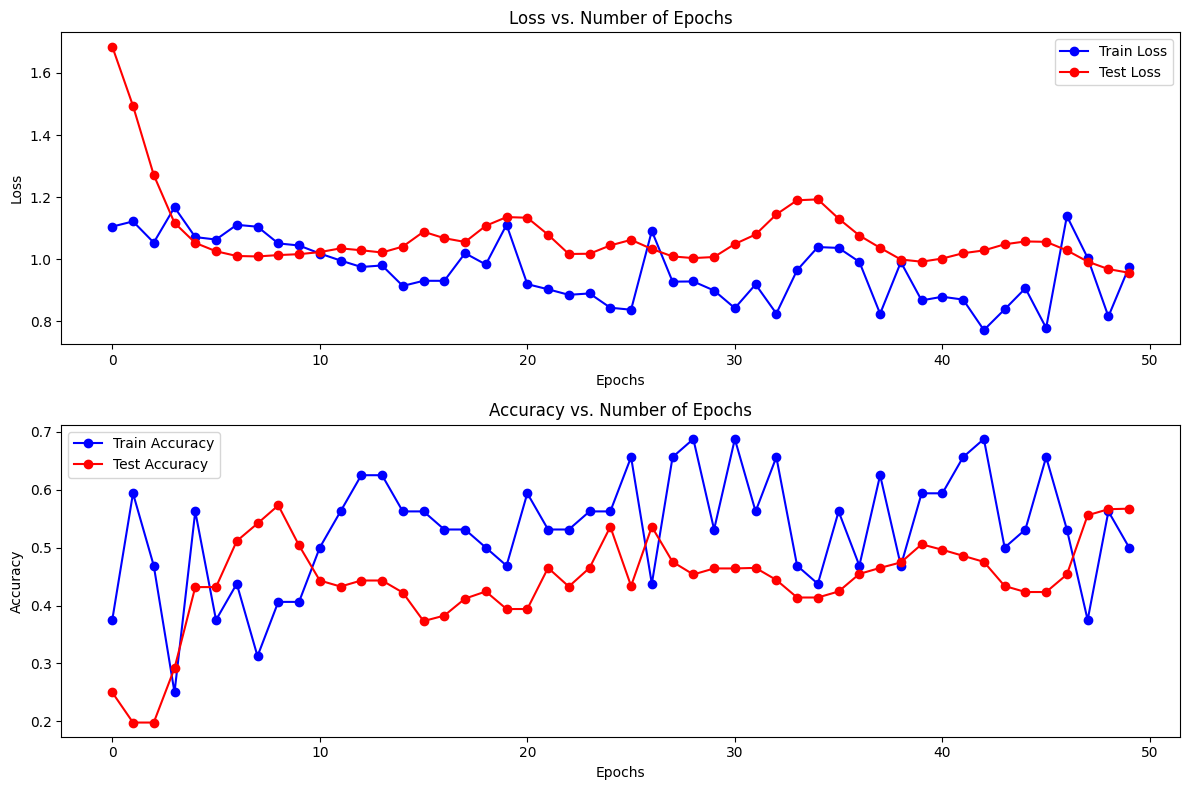

In [355]:
plot_results(results_model_1)

In [356]:
## 10. Compare the results of the models

In [358]:
import pandas as pd
model_0_df = pd.DataFrame(results_model_0)
model_1_df = pd.DataFrame(results_model_1)

model_0_df[:5]

,train_loss,test_loss,train_accuracy,test_accuracy
0,1.078208,1.096024,tensor(0.4062),0.541667
1,1.184455,0.996679,tensor(0.4688),0.541667
2,1.212337,1.087373,tensor(0.2500),0.260417
3,1.091648,1.146485,tensor(0.3125),0.281250
4,1.075624,1.145453,tensor(0.4688),0.197917


In [379]:
def plot_model_comparison(model_0_df: pd.DataFrame, model_1_df: pd.DataFrame) -> None:
    """Plots the comparison of two models' training and testing metrics.

    Args:
        model_0_df (pd.DataFrame): DataFrame containing metrics for Model 0.
        model_1_df (pd.DataFrame): DataFrame containing metrics for Model 1.
    """
    # Setup a plot
    plt.figure(figsize=(15, 10))

    # Get the number of epochs
    epochs = range(len(model_0_df))

    # Plot the train loss
    plt.subplot(2, 2, 1)
    plt.plot(epochs, model_0_df["train_loss"], label="Model 0")
    plt.plot(epochs, model_1_df["train_loss"], label="Model 1")
    plt.title("Train Loss")
    plt.xlabel("Epochs")
    plt.legend()

    # Plot the test loss
    plt.subplot(2, 2, 2)
    plt.plot(epochs, model_0_df["test_loss"], label="Model 0")
    plt.plot(epochs, model_1_df["test_loss"], label="Model 1")
    plt.title("Test Loss")
    plt.xlabel("Epochs")

    # Plot the train accuracy
    plt.subplot(2, 2, 3)
    plt.plot(epochs, model_0_df["train_accuracy"], label="Model 0")
    plt.plot(epochs, model_1_df["train_accuracy"], label="Model 1")
    plt.title("Train Accuracy")
    plt.xlabel("Epochs")
    plt.legend()

    # Plot the test accuracy
    plt.subplot(2, 2, 4)
    plt.plot(epochs, model_0_df["test_accuracy"], label="Model 0")
    plt.plot(epochs, model_1_df["test_accuracy"], label="Model 1")
    plt.title("Test Accuracy")
    plt.xlabel("Epochs")
    plt.legend()

    plt.tight_layout()
    plt.show()

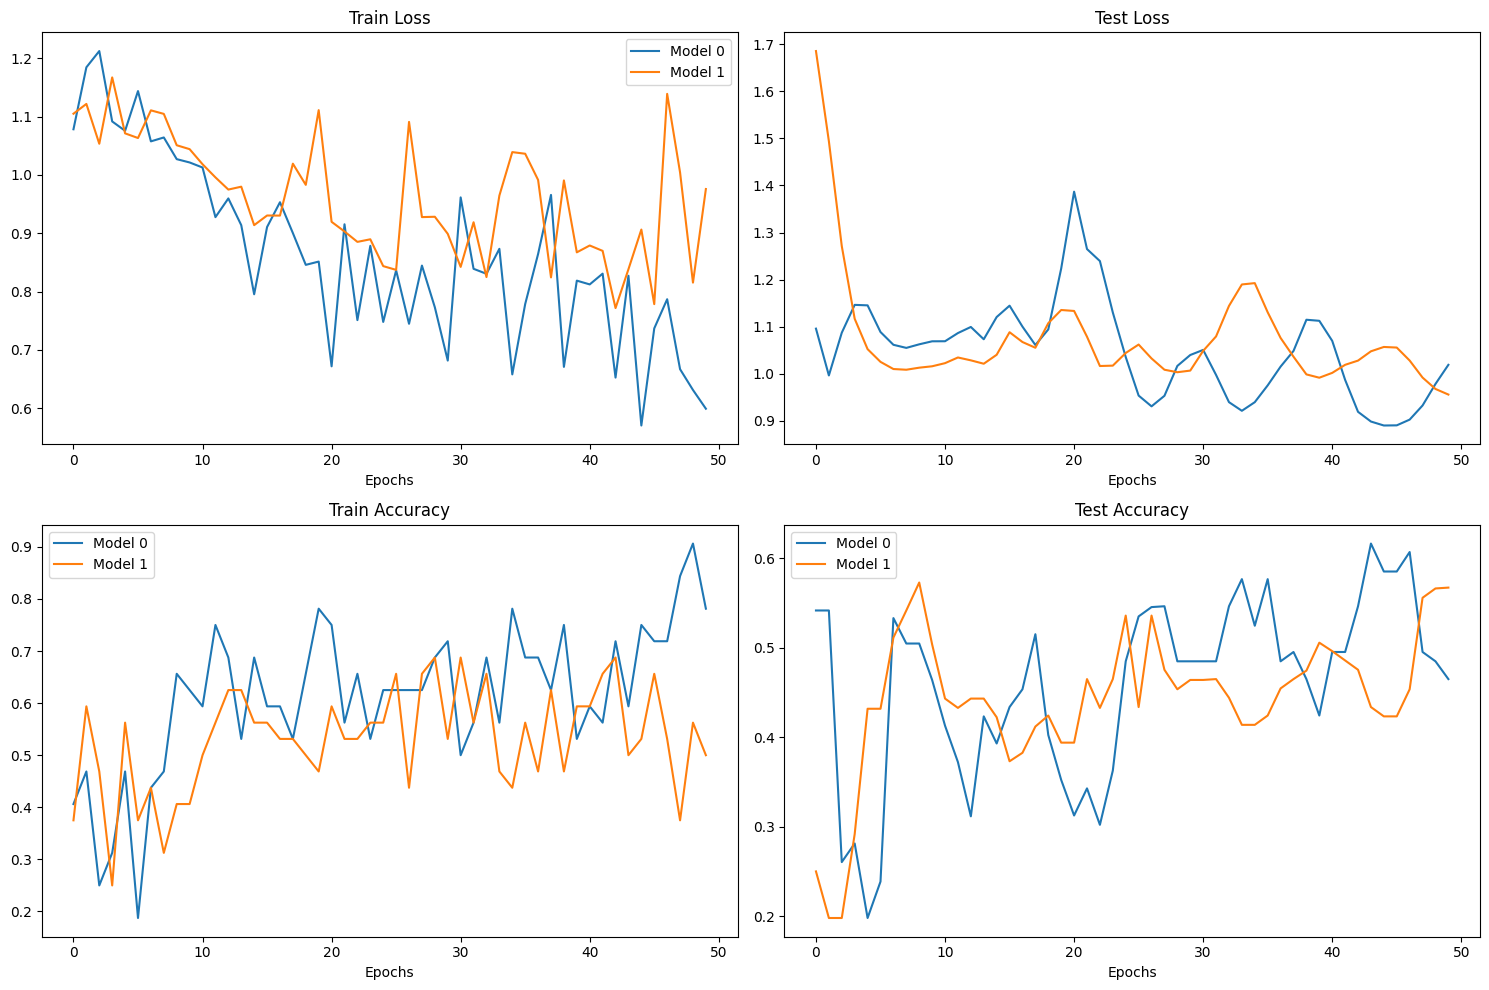

In [380]:
plot_model_comparison(model_0_df, model_1_df)

## 11. Making a prediction on a custom image

In [413]:
import requests

def download_custom_image(image_link: str, custom_image_dir: pathlib.PosixPath = Path("data/custom_images/"), custom_image_name: str = "01.jpeg") -> pathlib.PosixPath:
    """
    Downloads a custom image from a given URL and saves it to a specified directory.

    Args:
        image_link (str): URL of the image to download.
        custom_image_dir (pathlib.PosixPath): Directory to save the downloaded image.
        custom_image_name (str, optional): Name to save the image as. Defaults to "01.jpeg".

    Returns:
        pathlib.PosixPath: Path to the downloaded image.
    """
    # Create custom image directory if it doesn't exist
    custom_image_dir.mkdir(parents=True, exist_ok=True)

    # Setup custom image path
    custom_image_name = custom_image_name + ".jpeg" if not custom_image_name.endswith(".jpeg") else custom_image_name
    custom_image_path = custom_image_dir / custom_image_name

    # Download the image if it doesn't already exist
    if not custom_image_path.is_file():
        with open(custom_image_path, "wb") as file:
            request = requests.get(image_link)
            print(f"Downloading {custom_image_path} ...")
            file.write(request.content)
    else:
        print(f"{custom_image_path} already exists.")
    
    return custom_image_path

# Example usage
custom_image_dir = Path("data/custom_images/")
image_link = "https://www.simplyrecipes.com/thmb/h7H8UgA28OOJNGiP_bqXCYONB7o=/1500x0/filters:no_upscale():max_bytes(150000):strip_icc():format(webp)/__opt__aboutcom__coeus__resources__content_migration__simply_recipes__uploads__2019__09__easy-pepperoni-pizza-lead-4-82c60893fcad4ade906a8a9f59b8da9d.jpg"

custom_image_path = download_custom_image(image_link, custom_image_dir, custom_image_name="pizza")

### 11.1 Load and preprocess the custom image

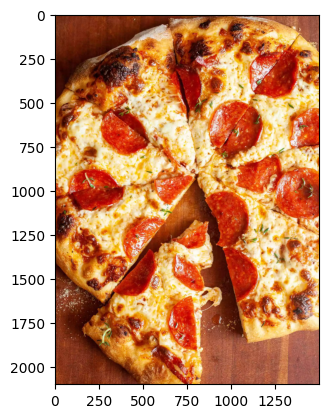

In [393]:
# Load the custom image
from PIL import Image

custom_image = Image.open(custom_image_path)

# Display the custom image
plt.imshow(custom_image)

In [394]:

# Create a transform for the custom image
custom_transform = transforms.Compose([
    transforms.ToImage(),
    transforms.Resize((64, 64)),
    transforms.ToDtype(torch.float32, scale=True),
    transforms.ToImage(),
])

# Transform the custom image
custom_image_transformed = custom_transform(custom_image)
custom_image_transformed.shape


torch.Size([3, 64, 64])

In [399]:
str(custom_image_path)

'data/custom_image/01.jpeg'

In [402]:
import torchvision
from PIL import Image

# Convert image to a supported format (JPEG)
custom_image = Image.open(custom_image_path).convert("RGB")
custom_image.save(custom_image_path, format="JPEG")

# Read in custom image
custom_image_uint8 = torchvision.io.read_image(str(custom_image_path))
custom_image_uint8

tensor([[[106, 105, 104,  ..., 166, 165, 151],
         [105, 105, 104,  ..., 163, 161, 147],
         [104, 103, 103,  ..., 157, 154, 142],
         ...,
         [135, 132, 130,  ..., 170, 170, 170],
         [129, 126, 125,  ..., 165, 165, 165],
         [125, 122, 121,  ..., 162, 162, 162]],

        [[ 45,  44,  43,  ..., 100,  99,  85],
         [ 44,  44,  43,  ...,  97,  95,  81],
         [ 43,  42,  42,  ...,  91,  88,  76],
         ...,
         [ 58,  55,  53,  ..., 102, 102, 102],
         [ 52,  49,  48,  ...,  97,  97,  97],
         [ 48,  45,  44,  ...,  94,  94,  94]],

        [[ 16,  15,  14,  ...,  74,  73,  59],
         [ 15,  15,  14,  ...,  71,  69,  55],
         [ 14,  13,  13,  ...,  65,  62,  50],
         ...,
         [ 32,  29,  27,  ...,  91,  91,  91],
         [ 26,  23,  22,  ...,  86,  86,  86],
         [ 22,  19,  18,  ...,  83,  83,  83]]], dtype=torch.uint8)

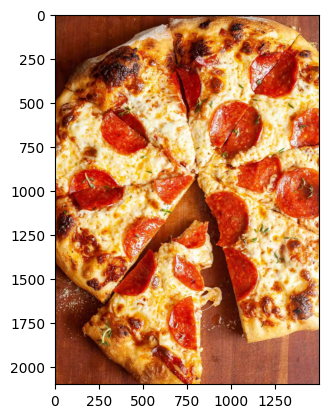

In [403]:
plt.imshow(custom_image_uint8.permute(1, 2, 0))

In [404]:
### 11.2 Making a prediction on a custom image with the trained model

In [405]:
# Try to make a prediction on the custom image

def predict_image(model: nn.Module,
                    image_path: str,
                    transform: transforms.Compose,
                    class_names: List[str]) -> Tuple[str, float]:
        """Predicts the class of an image.
    
        Args:
            model (nn.Module): A PyTorch neural network model.
            image_path (str): The path to the image.
            transform (transforms.Compose): A PyTorch transformation.
            class_names (List[str]): A list of class names.

        Returns:
            Tuple[str, float]: A tuple containing the class name and the probability.
        """
        # Load the image
        image = Image.open(image_path).convert("RGB")
        image = transform(image)
        image = image.unsqueeze(0)

        # Make a prediction
        model.eval()
        with torch.inference_mode():
            predictions = model(image)
            predicted_probabilities = torch.softmax(predictions, dim=1)
            predicted_class_index = torch.argmax(predicted_probabilities, dim=1)
            predicted_class_name = class_names[predicted_class_index]
            predicted_probability = predicted_probabilities[0][predicted_class_index].item()

        return predicted_class_name, predicted_probability


In [414]:
# Make a prediction on the custom image
predicted_class_name, predicted_probability = predict_image(model_1,
                                                             str(custom_image_path),
                                                             custom_transform,
                                                             train_data.classes)

In [415]:
predicted_class_name, predicted_probability

('pizza', 0.4494563639163971)

In [416]:
# Download a custom image
image_link = "https://jesspryles.com/wp-content/uploads/2020/04/untitled-2-1024x640.jpg"

custom_image_path = download_custom_image(image_link, custom_image_dir, custom_image_name="steak")

# Make a prediction on the custom image
predicted_class_name, predicted_probability = predict_image(model_1,
                                                             str(custom_image_path),
                                                             custom_transform,
                                                             train_data.classes)

predicted_class_name, predicted_probability

('steak', 0.46396979689598083)

In [424]:
# Download a custom image
image_link = "https://cdn.shoplightspeed.com/shops/624895/files/50052936/890x820x2/momentum-voya-e-1-2024-velo-electrique-de-route-gr.jpg"

custom_image_path = download_custom_image(image_link, custom_image_dir, custom_image_name="another_image")

# Make a prediction on the custom image
predicted_class_name, predicted_probability = predict_image(model_1,
                                                             str(custom_image_path),
                                                             custom_transform,
                                                             train_data.classes)

predicted_class_name, predicted_probability

data/custom_images/another_image.jpeg already exists.


('sushi', 0.40321463346481323)

In [426]:
train_data.classes

['pizza', 'steak', 'sushi']

In [427]:
model_1.state_dict()

OrderedDict([('conv_block_1.0.weight',
              tensor([[[[-0.0882, -0.0089, -0.0447],
                        [-0.0908, -0.1344,  0.0907],
                        [ 0.1540, -0.0631, -0.0326]],
              
                       [[-0.0881,  0.0849, -0.0223],
                        [ 0.0166, -0.0731, -0.1569],
                        [-0.0122,  0.1511,  0.0509]],
              
                       [[ 0.1731, -0.0033, -0.0627],
                        [ 0.0801, -0.1438, -0.0330],
                        [ 0.1789, -0.1479, -0.0067]]],
              
              
                      [[[-0.0402, -0.0369,  0.0993],
                        [-0.0268, -0.1223,  0.1732],
                        [ 0.0546,  0.0062, -0.0071]],
              
                       [[-0.1789, -0.0406,  0.1533],
                        [ 0.0404, -0.0844,  0.1678],
                        [ 0.1042,  0.0926, -0.0211]],
              
                       [[-0.0084, -0.1903,  0.1556],
                 

In [428]:
# Get the summary of the model
from torchinfo import summary

summary(model_1, input_size=(BATCH_SIZE, 3, 64, 64))

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [32, 3]                   --
├─Sequential: 1-1                        [32, 64, 31, 31]          --
│    └─Conv2d: 2-1                       [32, 64, 62, 62]          1,792
│    └─ReLU: 2-2                         [32, 64, 62, 62]          --
│    └─MaxPool2d: 2-3                    [32, 64, 31, 31]          --
├─Sequential: 1-2                        [32, 64, 14, 14]          --
│    └─Conv2d: 2-4                       [32, 64, 29, 29]          36,928
│    └─ReLU: 2-5                         [32, 64, 29, 29]          --
│    └─MaxPool2d: 2-6                    [32, 64, 14, 14]          --
├─Sequential: 1-3                        [32, 3]                   --
│    └─Flatten: 2-7                      [32, 12544]               --
│    └─Linear: 2-8                       [32, 3]                   37,635
Total params: 76,355
Trainable params: 76,355
Non-trainable params: 0
Tota

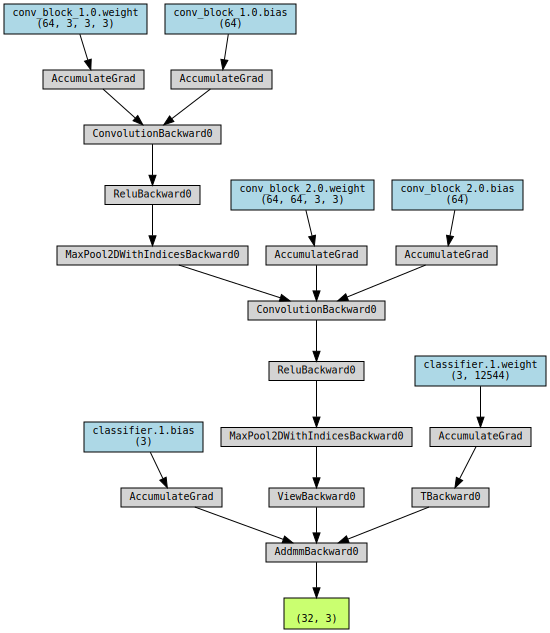

In [435]:
from torchviz import make_dot

# Get a single batch from the dataloader
img, label = next(iter(train_dataloader_simple))

# Perform a forward pass to get the model's output
output = model_0(img)

# Visualize the model
make_dot((output), params=dict(model_0.named_parameters()))


## 10. Save and load the best performing model

In [460]:
from pathlib import Path

# Create a directory to save the model
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(exist_ok=True,
                parents=True)

# Create model save path
MODEL_NAME = "TinyVGG.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Save the model
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(model_1, MODEL_SAVE_PATH)

Saving model to: models/TinyVGG.pth
